<a href="https://colab.research.google.com/github/LrisMa/EIE4435-Lab2/blob/main/EIE4435/Programs/Digital_Audio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### This script demonstrates how dithering can be applied to low-amplitude signals that are vulnerable to quantization error. After setting the variables, you may click "Runtime > Run all" (if you use Colab) or click the "Run All" button (if you use Visual Studio Code) to run all cells in one operation.

## Procedures
1. Read the codes in this .ipynb file to understand how they work.
1. set *use_colab* to True if you use Google Colab; otherwise, set it to False.
1. Set *source* to 'tone'.   
1. Run all cells. Listen to the audio of (1) the original signal, (2) the quantized version of the amplitude-reduced signal, and (3) the quantized version of the amplitude-reduced signal after adding noise (dithering).
1. Repeat Step 3 by setting *source* to 'music'.
1. Change the constant *n_bits* to 4 and repeat Steps 3-5.
1. Vary other variables to see their effect on the audio quality.


## Answer the following questions
1. When the signal amplitude is high enough (e.g., without any amplitude reduction), the quantized signal "xq" is perceptually close to the original signal "x" even at a bit depth of 8. Why is this the case?
1. When the variable *amp_red_ratio* was set to 32, the quantized waveform "yq" did not look like the original waveform "y". Why is this the case?
1. When the bit-depth is 4 (*n_bits = 4*), the quantization error becomes periodic. How will this kind of quantization error affect the audio quality of the quantized signal?
1. Why does adding a small amount of noise to the signal that is vulnerable to quantization error help to reduce the detrimental effect of the quantization error?
1. When *source* is set to 'tone', explain why severe quantization noise can change the perceptual frequency of the tone. You may check this phenomenon by listening to the audio of "yq".


In [1]:
import matplotlib.pyplot as plt
import librosa
import numpy as np
from IPython.display import Audio

In [2]:
# Define some variables
source = 'tone'            # Either 'tone' or 'music'
use_colab = True            # Set to False if you use local IDE such as Visual Studio Code
sr = 16000                  # Sampling rate of the target signal
duration = 5                # Duration of the target signal
n_bits = 8                  # Bit depth for the quantized signal
amp_red_ratio= 32           # Reduce the amplitude of the signal by this factor
noise_var_ratio = 20        # Noise ratio for dithering

In [3]:
# Mount Google Drive and create a folder for the lab exercise
if use_colab == True:
  from google.colab import drive
  drive.mount('/content/drive')
  !mkdir -p /content/drive/MyDrive/Learning/EIE4435/Programs
  %cd /content/drive/MyDrive/Learning/EIE4435/Programs

Mounted at /content/drive
/content/drive/MyDrive/Learning/EIE4435/Programs


In [4]:
# Function for plotting one frame of unquantized waveform, one frame of quantized waveform, and their spectrograms
def plot_figure(x, xq, sr=16000, frm_len=512, hop_len=256):
    '''
    x: waveform
    xq: quantized waveform
    '''
    e = xq - x
    X = librosa.amplitude_to_db(np.abs(librosa.stft(x, n_fft=512, hop_length=256)), ref=np.max)  # STFT of x
    Xq = librosa.amplitude_to_db(np.abs(librosa.stft(xq, n_fft=512, hop_length=256)), ref=np.max)  # STFT of xq
    E = librosa.amplitude_to_db(np.abs(librosa.stft(e, n_fft=512, hop_length=256)), ref=np.max)  # STFT of e

    _, ax = plt.subplots(nrows=3, sharex=True, figsize=(8,3))
    smp_idx = range(2*frm_len, 3*frm_len)
    librosa.display.waveshow(x[smp_idx], sr=sr, ax=ax[0])
    ax[0].set_ylabel('x')
    librosa.display.waveshow(xq[smp_idx], sr=sr, ax=ax[1])
    ax[1].set_ylabel('xq')
    librosa.display.waveshow(e[smp_idx], sr=sr, ax=ax[2])
    ax[2].set_ylabel('e')
    _, ax = plt.subplots(nrows=3, sharex=True, figsize=(8,3))
    librosa.display.specshow(X, sr=sr, n_fft=frm_len, hop_length=hop_len, x_axis='time', y_axis='linear', ax=ax[0])
    librosa.display.specshow(Xq, sr=sr, n_fft=frm_len, hop_length=hop_len, x_axis='time', y_axis='linear', ax=ax[1])
    librosa.display.specshow(E, sr=sr, n_fft=frm_len, hop_length=hop_len, x_axis='time', y_axis='linear', ax=ax[2])

In [5]:
# Function for performing quanitzation
def quantize(y, n_bits=8, xmax=1):
    Q = 2 * xmax/(2**n_bits)
    yq = y/2 * (2**(n_bits-1) + 2**(n_bits-1) - 1)
    yq = np.floor(yq).astype(int).astype(float)*Q
    print(f"{n_bits}-bit audio ranges from -{2**(n_bits - 1)*Q} to {(2**(n_bits - 1) - 1)*Q} for xmax={xmax} and Q={Q}")
    print(f"Max quantized value: {np.max(yq)}, Avg quantized value: {np.mean(yq):.2f}")
    return yq

In [6]:
# Check a 3-bit quantizer with xmax=1
y = np.array([-1, -0.8, -0.6, -0.4, -0.2, 0.0, 0.2, 0.4, 0.6, 0.8, 1.0])    # y ranges from -xmax to xmax
yq = quantize(y, n_bits=3, xmax=1)
np.set_printoptions(precision=2, floatmode='fixed')
print(f"y =  {y}")
print(f"yq = {yq}")
print(f"e =  {yq-y}")

3-bit audio ranges from -1.0 to 0.75 for xmax=1 and Q=0.25
Max quantized value: 0.75, Avg quantized value: -0.11
y =  [-1.00 -0.80 -0.60 -0.40 -0.20  0.00  0.20  0.40  0.60  0.80  1.00]
yq = [-1.00 -0.75 -0.75 -0.50 -0.25  0.00  0.00  0.25  0.50  0.50  0.75]
e =  [ 0.00  0.05 -0.15 -0.10 -0.05  0.00 -0.20 -0.15 -0.10 -0.30 -0.25]


In [7]:
if source == 'music':
    # Load a wavefile and crop a 2-second segment from it
    x, fs = librosa.load('../AudioFiles/Bach.mp3', mono=True, offset=0.0, duration=duration)
    x = librosa.resample(x, orig_sr=fs, target_sr=sr)
    x = ((x-np.min(x))/(np.max(x)-np.min(x))-0.5)*2
else:
    # Generate a tone of 500Hz with a sampling rate of 16kHz
    x = librosa.tone(500, sr=sr, length=sr*2)
    x = ((x-np.min(x))/(np.max(x)-np.min(x))-0.5)*2

8-bit audio ranges from -1.0 to 0.9921875 for xmax=1 and Q=0.0078125
Max quantized value: 0.9921875, Avg quantized value: -0.00


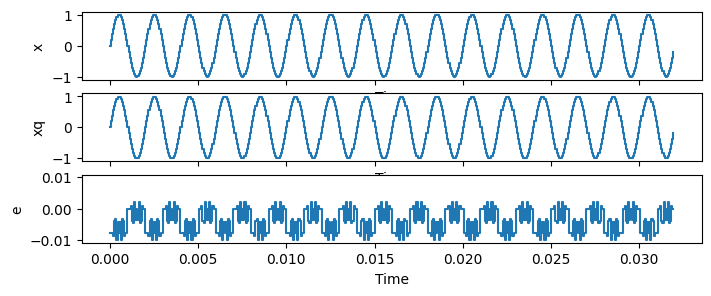

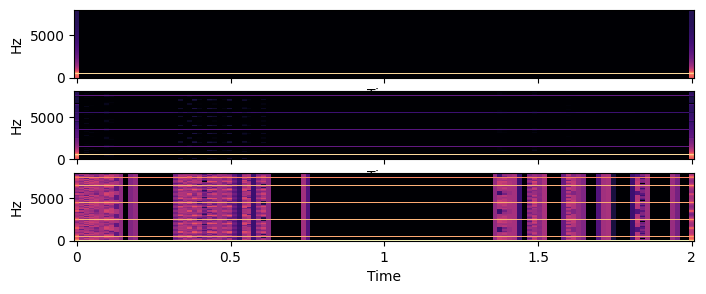

In [8]:
xq = quantize(x, n_bits=n_bits)
plot_figure(x, xq, sr=sr)

In [9]:
# Reduce the amplitude of the signal to make it more vulnerable to quanization error.
# Reduce the number of bits per sample
y = x/amp_red_ratio
yq = quantize(y, n_bits=n_bits, xmax=1)

8-bit audio ranges from -1.0 to 0.9921875 for xmax=1 and Q=0.0078125
Max quantized value: 0.0234375, Avg quantized value: -0.00


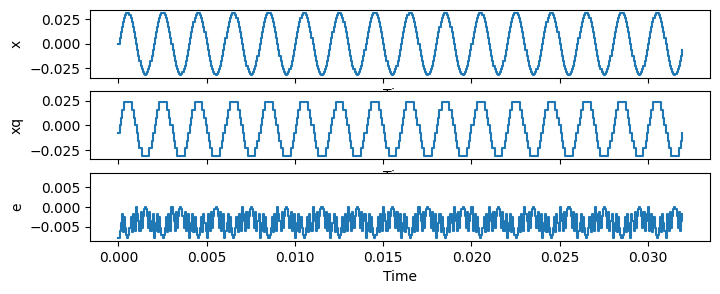

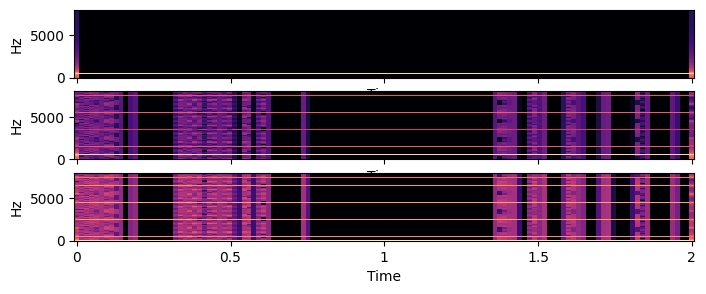

In [10]:
# Plot a short segment of the low-amplitude waveform, quantized waveform, quantization error, and their spectrograms
plot_figure(y, yq, sr=sr)

In [11]:
# Perform dithering by adding Gaussian noise
noise_var = np.max(np.abs(y))/noise_var_ratio         # Variance of Gaussian noise for dithering
z = y + np.random.normal(0, noise_var, yq.shape[0])
zq = quantize(z, n_bits=n_bits, xmax=1)

8-bit audio ranges from -1.0 to 0.9921875 for xmax=1 and Q=0.0078125
Max quantized value: 0.03125, Avg quantized value: -0.00


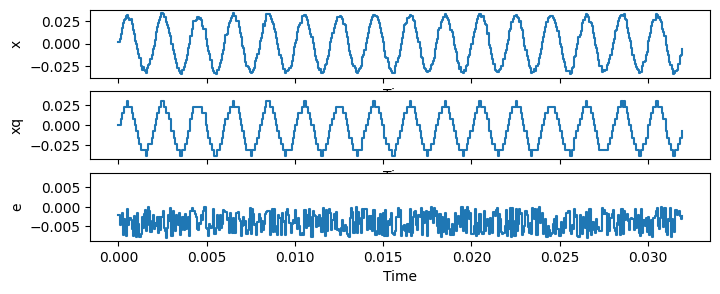

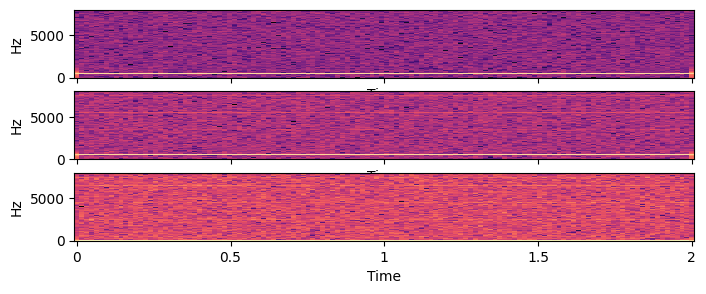

In [12]:
# Plot a frame of dithered signal, the quantization error, and their spectrograms
plot_figure(z, zq, sr=sr)

In [13]:
# Listen to the original waveform
Audio(data=x, rate=sr)

In [ ]:
# Listen to the quantized waveform (without amplitude reduction)
Audio(data=xq, rate=sr)

In [ ]:
# Listen to the quantized waveform (with amplitude reduction)
Audio(data=yq, rate=sr)

In [ ]:
# Listen to the quantized waveform of the dithered signal (with amplitude reduction)
Audio(data=zq, rate=sr)